In [12]:
import optuna
import numpy as np  
import optuna.visualization as vis
import os
import plotly
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import seaborn as sns



In [13]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [31]:
number_top=100
study_directory = "Estudios/Small_world"  # Asegúrate de que este sea el directorio correcto



Global Trial 1:
Study: Chi30_zscore_L70
Params: {'L': 79, 'P': 0.5868283597817546, 'Inh': 0.44252569928366114, 'Trest': 0.3783744290236525, 'Trelative': 0.5866441786622993, 'C_h': 0.004234514916017356, 'Tipo_red': 1}
Sum of Values: 19.537501663625758
---------------------------------------
Global Trial 2:
Study: Chi30_zscore_L70
Params: {'L': 80, 'P': 0.5366863642900316, 'Inh': 0.436487496363798, 'Trest': 0.56260376413653, 'Trelative': 0.7919268017096182, 'C_h': 0.07227922972852738, 'Tipo_red': 1}
Sum of Values: 24.90569715152016
---------------------------------------
Global Trial 3:
Study: Chi30_zscore_L20
Params: {'L': 25, 'P': 0.07267055650990248, 'Inh': 0.31104050066435, 'Trest': 0.17682748904729645, 'Trelative': 0.4199743607027754, 'C_h': 0.8453688325923857, 'Tipo_red': 2}
Sum of Values: 26.996025322379584
---------------------------------------
Frecuencia de aparición de cada estudio en los mejores 100 ensayos:
Estudio Chi30_zscore_L70: 29 veces
Estudio Chi30_zscore_L20: 13 vece

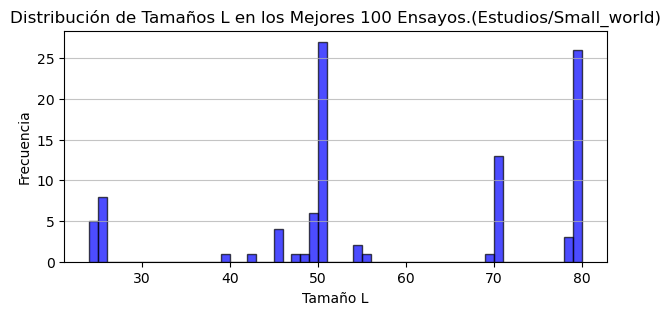

In [33]:
# Directorio donde están almacenados los estudios

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)




# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos
best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:3]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")
    study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L

# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)
size_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
     network_type_frequency_count[network_type] += 1

for size in sizes:
    size_frequency_count[size] += 1  # Contar la frecuencia de cada tamaño L

print(f"Frecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"Frecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")

mean_size = np.mean(sizes)
print(f"\nMedia del tamaño L en los mejores {number_top} ensayos: {mean_size}")

# Graficar la distribución de los tamaños L
plt.figure(figsize=(7, 3))
plt.hist(sizes, bins=range(min(sizes), max(sizes) + 1), alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Distribución de Tamaños L en los Mejores {number_top} Ensayos.({study_directory})')
plt.xlabel('Tamaño L')
plt.ylabel('Frecuencia')
#plt.xticks(range(min(sizes), max(sizes) + 1,3))
plt.grid(axis='y', alpha=0.75)
plt.show()


In [34]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L
trest_values = [trial.params['Trest'] for trial in best_trials_global]  # Recopilar Trest
trela_values = [trial.params['Trelative'] for trial in best_trials_global]  # Recopilar Trest
Chiper=[trial.params['C_h'] for trial in best_trials_global]  # Recopilar Trest

P_values = [trial.params['P'] for trial in best_trials_global]  # Recopilar P
Inh_values = [trial.params['Inh'] for trial in best_trials_global]  # Recopilar P
# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1
print(f"\nMedia del L: {np.mean(sizes)}")
print(f"Desviación estándar del L: {np.std(sizes)}")
print(f"Mediana del L: { np.median(sizes)}")
print(f"Primer cuartil (Q1) del L: {np.percentile(sizes, 25)}")
print(f"Tercer cuartil (Q3) del L: {np.percentile(sizes, 75)}")


print(f"\nMedia del Trest: {np.mean(trest_values)}")
print(f"Desviación estándar del Trest: {np.std(trest_values)}")
print(f"Mediana del Trest: {np.median(trest_values)}")
print(f"Primer cuartil (Q1) del Trest: {np.percentile(trest_values, 25)}")
print(f"Tercer cuartil (Q3) del Trest: {np.percentile(trest_values, 75)}")

print(f"\nMedia del Trela: {np.mean(trela_values)}")
print(f"Desviación estándar del Trela: {np.std(trela_values)}")
print(f"Mediana del Trela: {np.median(trela_values)}")
print(f"Primer cuartil (Q1) del Trela: {np.percentile(trela_values, 25)}")
print(f"Tercer cuartil (Q3) del Trela: {np.percentile(trela_values, 75)}")

print(f"\nMedia del P: {np.mean(P_values)}")
print(f"Desviación estándar del P: {np.std(P_values)}")
print(f"Mediana del P: { np.median(P_values)}")
print(f"Primer cuartil (Q1) del P: {np.percentile(P_values, 25)}")
print(f"Tercer cuartil (Q3) del P: {np.percentile(P_values, 75)}")

print(f"\nMedia del Inh: {np.mean(Inh_values)}")
print(f"Desviación estándar del Inh: {np.std(Inh_values)}")
print(f"Mediana del Inh: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del Inh: {np.percentile(Inh_values, 25)}")
print(f"Tercer cuartil (Q3) del Inh: {np.percentile(Inh_values, 75)}")

print(f"\nMedia del C hiper: {np.mean(Chiper)}")
print(f"Desviación estándar del C hiper: {np.std(Chiper)}")
print(f"Mediana del C hiper: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del C hiper: {np.percentile(Chiper, 25)}")
print(f"Tercer cuartil (Q3) del C hiperh: {np.percentile(Chiper, 75)}")


Media del L: 57.55
Desviación estándar del L: 18.19745861377352
Mediana del L: 50.0
Primer cuartil (Q1) del L: 49.0
Tercer cuartil (Q3) del L: 79.0

Media del Trest: 0.2550716347022922
Desviación estándar del Trest: 0.1817838786991601
Mediana del Trest: 0.1960342332704779
Primer cuartil (Q1) del Trest: 0.16768920542424945
Tercer cuartil (Q3) del Trest: 0.3396254369361685

Media del Trela: 1.3042333448710914
Desviación estándar del Trela: 2.569802559991799
Mediana del Trela: 0.43679778187743484
Primer cuartil (Q1) del Trela: 0.3543927350230487
Tercer cuartil (Q3) del Trela: 0.5931218599439343

Media del P: 0.4156757341216284
Desviación estándar del P: 0.17880810674439013
Mediana del P: 0.43354577326852073
Primer cuartil (Q1) del P: 0.3376773387197404
Tercer cuartil (Q3) del P: 0.5564622588529718

Media del Inh: 0.36271641185223413
Desviación estándar del Inh: 0.053983878879335555
Mediana del Inh: 0.3517442168799658
Primer cuartil (Q1) del Inh: 0.32483087212285583
Tercer cuartil (Q3) de

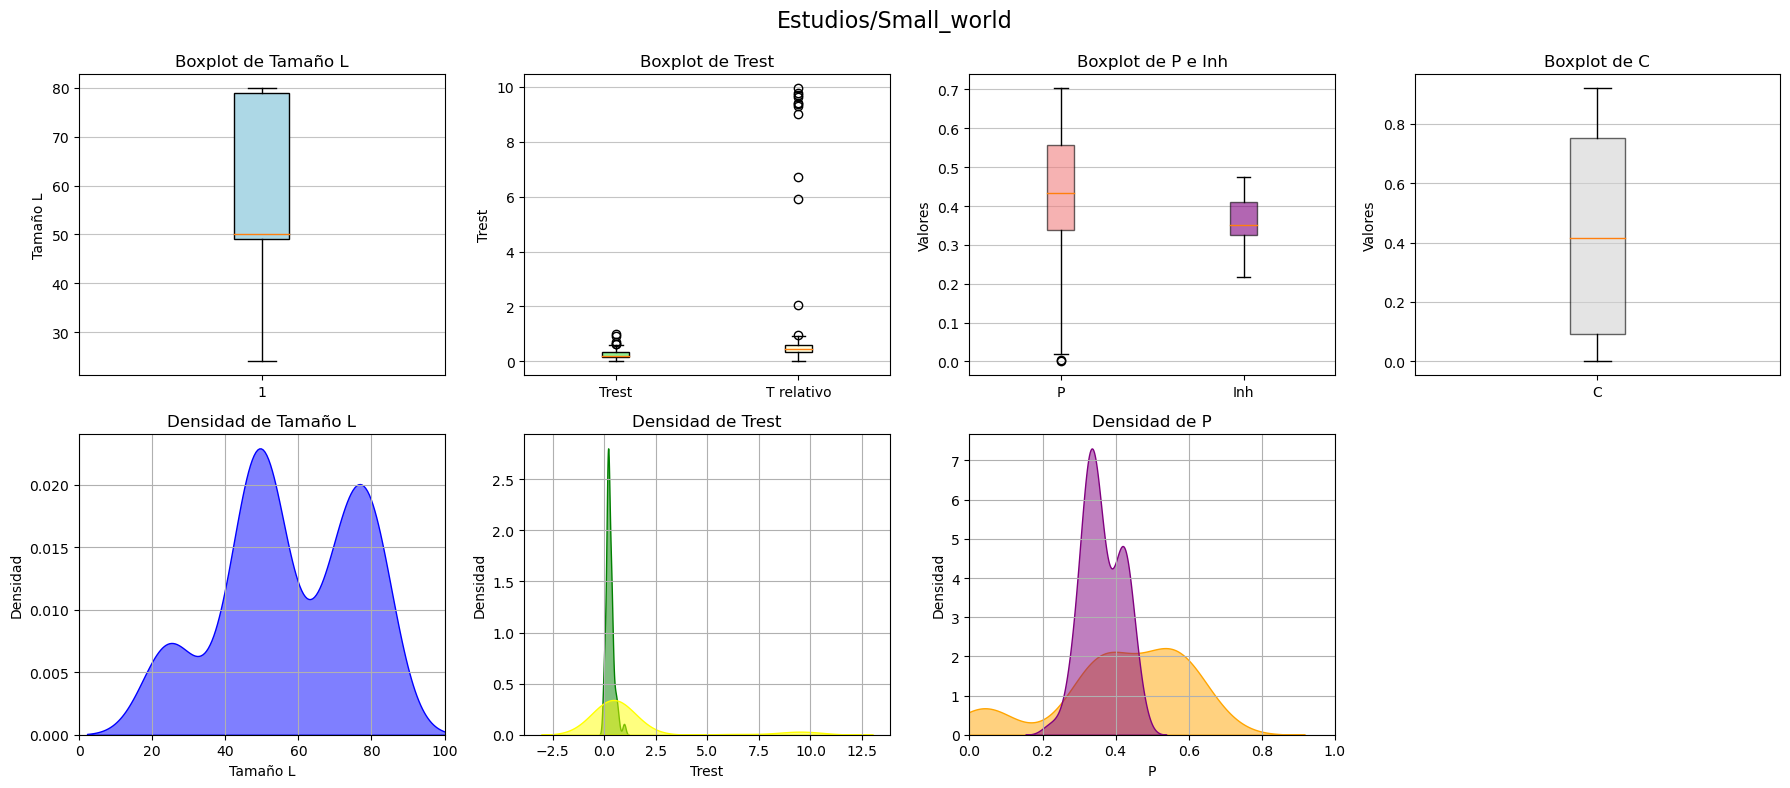

In [35]:
plt.figure(figsize=(18, 8))

# Boxplot de Tamaño L
plt.subplot(2, 4, 1)
plt.boxplot(sizes, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Tamaño L')
plt.ylabel('Tamaño L')
plt.grid(axis='y', alpha=0.75)

# Boxplot de Trest
plt.subplot(2, 4, 2)
plt.boxplot(trest_values, patch_artist=True, boxprops=dict(facecolor='lightgreen'),labels=["Trest"])
plt.boxplot(trela_values, patch_artist=True, boxprops=dict(facecolor='lightyellow'),positions=[2],labels=['T relativo'])
plt.title('Boxplot de Trest')
plt.ylabel('Trest')
plt.grid(axis='y', alpha=0.75)

# Boxplot de P
plt.subplot(2, 4, 3)
plt.boxplot(P_values, patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.6), labels=['P'])  # Asignar etiqueta para P
plt.boxplot(Inh_values, patch_artist=True, boxprops=dict(facecolor='purple', alpha=0.6), positions=[2])  # Asignar etiqueta para Inh, en posición 2
plt.title('Boxplot de P e Inh')
plt.ylabel('Valores')
plt.xticks([1, 2], ['P', 'Inh'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 4, 4)
plt.boxplot(Chiper, patch_artist=True, boxprops=dict(facecolor='lightgrey', alpha=0.6), labels=['C'])  # Asignar etiqueta para P
plt.title('Boxplot de C')
plt.ylabel('Valores')
plt.xticks([1], ['C'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)


plt.subplot(2, 4, 5)
sns.kdeplot(sizes, fill=True, color='blue', alpha=0.5)
plt.title('Densidad de Tamaño L')
plt.xlabel('Tamaño L')
plt.xlim(0,100)
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para Trest
plt.subplot(2, 4, 6)
sns.kdeplot(trest_values, fill=True, color='green', alpha=0.5)
sns.kdeplot(trela_values, fill=True, color='yellow', alpha=0.5)
plt.title('Densidad de Trest')
plt.xlabel('Trest')
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para P
plt.subplot(2, 4, 7)
sns.kdeplot(P_values, fill=True, color='orange', alpha=0.5)
sns.kdeplot(Inh_values, fill=True, color='purple', alpha=0.5)
plt.title('Densidad de P')
plt.xlabel('P')
plt.xlim(0,1)
plt.ylabel('Densidad')
plt.grid()

plt.tight_layout()
plt.suptitle(study_directory, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Ajustar para evitar superposición con el título
plt.show()


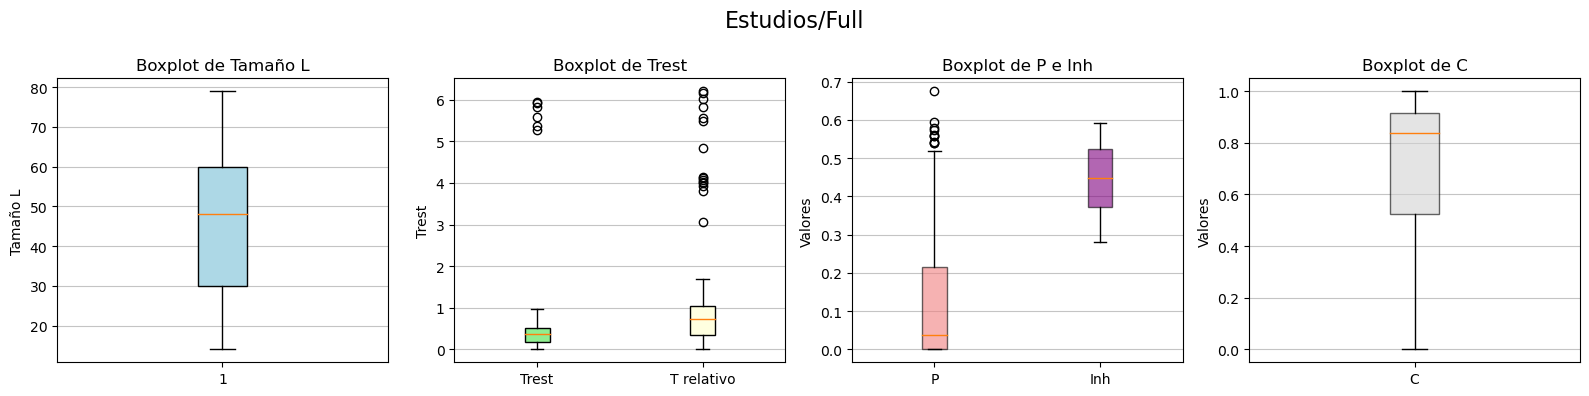

In [29]:
plt.figure(figsize=(16, 4))

# Boxplot de Tamaño L
plt.subplot(1, 4, 1)
plt.boxplot(sizes, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Tamaño L')
plt.ylabel('Tamaño L')
plt.grid(axis='y', alpha=0.75)

# Boxplot de Trest
plt.subplot(1, 4, 2)
plt.boxplot(trest_values, patch_artist=True, boxprops=dict(facecolor='lightgreen'),labels=["Trest"])
plt.boxplot(trela_values, patch_artist=True, boxprops=dict(facecolor='lightyellow'),positions=[2],labels=['T relativo'])
plt.title('Boxplot de Trest')
plt.ylabel('Trest')
plt.grid(axis='y', alpha=0.75)

# Boxplot de P
plt.subplot(1, 4, 3)
plt.boxplot(P_values, patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.6), labels=['P'])  # Asignar etiqueta para P
plt.boxplot(Inh_values, patch_artist=True, boxprops=dict(facecolor='purple', alpha=0.6), positions=[2])  # Asignar etiqueta para Inh, en posición 2
plt.title('Boxplot de P e Inh')
plt.ylabel('Valores')
plt.xticks([1, 2], ['P', 'Inh'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 4, 4)
plt.boxplot(Chiper, patch_artist=True, boxprops=dict(facecolor='lightgrey', alpha=0.6), labels=['C'])  # Asignar etiqueta para P
plt.title('Boxplot de C')
plt.ylabel('Valores')
plt.xticks([1], ['C'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)


# plt.subplot(2, 4, 5)
# sns.kdeplot(sizes, fill=True, color='blue', alpha=0.5)
# plt.title('Densidad de Tamaño L')
# plt.xlabel('Tamaño L')
# plt.xlim(0,100)
# plt.ylabel('Densidad')
# plt.grid()

# # Gráfico de densidad para Trest
# plt.subplot(2, 4, 6)
# sns.kdeplot(trest_values, fill=True, color='green', alpha=0.5)
# sns.kdeplot(trela_values, fill=True, color='yellow', alpha=0.5)
# plt.title('Densidad de Trest')
# plt.xlabel('Trest')
# plt.ylabel('Densidad')
# plt.grid()

# # Gráfico de densidad para P
# plt.subplot(2, 4, 7)
# sns.kdeplot(P_values, fill=True, color='orange', alpha=0.5)
# sns.kdeplot(Inh_values, fill=True, color='purple', alpha=0.5)
# plt.title('Densidad de P')
# plt.xlabel('P')
# plt.xlim(0,1)
# plt.ylabel('Densidad')
# plt.grid()

plt.tight_layout()
plt.suptitle(study_directory, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Ajustar para evitar superposición con el título
plt.show()

In [12]:

# Configura la carpeta donde están los estudios y el archivo de salida
carpeta_estudios = "Estudios/Small_world"
output_file = "resultados_SW.txt"

# Obtener nombres de parámetros de un estudio de ejemplo
sample_study_path = None
for archivo in os.listdir(carpeta_estudios):
    if archivo.endswith(".db"):
        sample_study_path = os.path.join(carpeta_estudios, archivo)
        break

if sample_study_path is None:
    raise FileNotFoundError("No se encontró ningún archivo de estudio en la carpeta especificada.")

# Cargar un estudio de ejemplo para obtener los nombres de los parámetros
sample_study_name = os.path.basename(sample_study_path).replace(".db", "")
sample_study = optuna.load_study(study_name=sample_study_name, storage=f"sqlite:///{sample_study_path}")
param_names = list(sample_study.trials[0].params.keys())

# Crear o abrir el archivo de salida
with open(output_file, "w") as f:
    # Escribir encabezado con nombres de parámetros
    header = ["Estudio", "Ensayo", "chi2"] + param_names
    f.write("\t".join(header) + "\n")


    # Iterar sobre cada archivo en la carpeta
    for archivo in os.listdir(carpeta_estudios):
        # Verificar que el archivo sea una base de datos SQLite (opcional)
        if archivo.endswith(".db"):
            # Obtener el nombre completo del archivo
            db_path = os.path.join(carpeta_estudios, archivo)
            study_name = archivo.replace(".db", "")  # Asumimos que el nombre del archivo es el nombre del estudio

            # Cargar el estudio
            try:
                study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{db_path}")

                # Iterar sobre los ensayos del estudio
                for trial in study.trials:
                    # Filtrar ensayos con valores de chi2 no finitos
                    chi2_value = trial.value
                    if chi2_value is not None and not (chi2_value == float("inf") or chi2_value == float("-inf")):
                        # Extraer valores de parámetros en el orden de param_names
                        param_values = [trial.params.get(name, "N/A") for name in param_names]

                        # Escribir el resultado en el archivo con el nombre del estudio
                        f.write(f"{study_name}\t{trial.number}\t{chi2_value:.4f}\t" + "\t".join(map(str, param_values)) + "\n")

            except Exception as e:
                print(f"Error al cargar el estudio {study_name}: {e}")

print(f"Resultados guardados en {output_file}")


Resultados guardados en resultados_SW.txt


# Comparaciones 

In [198]:

# Directorio donde están almacenados los estudios
study_directory = "Estudios/Full/"  # Ajusta según sea necesario
study_name = "Chi30_zscore_L70"  # Cambia al nombre de tu estudio
# Cargar el estudio
study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_directory}{study_name}.db")
# Obtener el número de pruebas
num_trials = len(study.trials)

# Imprimir el número de pruebas
print(f"Número de pruebas en el estudio '{study_name}': {num_trials}")




Número de pruebas en el estudio 'Chi30_zscore_L70': 634


In [157]:
# Gráfico de correlación entre los parámetros y los objetivos
vis.plot_param_importances(study)


[W 2024-11-12 16:17:48,941] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,942] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,943] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,944] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,944] Trial 17 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,944] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,945] Trial 22 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,945] Trial 26 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,946] Trial 33 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-12 16:17:48,947] Tr

In [ ]:
# Gráfico de slice para explorar la relación entre los parámetros y los objetivos
%matplotlib inline
vis.plot_slice(study)


In [ ]:
# Gráfico de coordenadas paralelas para visualizar múltiples objetivos
%matplotlib inline
vis.plot_parallel_coordinate(study)
